<a href="https://colab.research.google.com/github/mrarat76/Tensorflow_Practises/blob/main/Tensor_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
## Transfer Learning

In [26]:
!nvidia-smi

Tue Mar  5 12:48:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              34W /  70W |   4221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
## Helper fonksiyonların oluşturulması (dışarıdan import ettirdik)

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-03-05 12:48:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-05 12:48:56 (43.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [28]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys,walk_through_dir

# Veri indirmesi

Food 101 verisinin sadece %10unu indiriyoruz.
Ancak bu image_data_modification adlı dosyada preprocess edilmiş.

In [29]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

--2024-03-05 12:48:56--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7912 (7.7K) [text/plain]
Saving to: ‘image_data_modification.ipynb.1’

image_data_modifica 100%[===================>]   7.73K  --.-KB/s    in 0s      

2024-03-05 12:48:57 (66.3 MB/s) - ‘image_data_modification.ipynb.1’ saved [7912/7912]



In [30]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-03-05 12:48:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.251.2.207, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   144MB/s    in 15s     

2024-03-05 12:49:12 (105 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [31]:
## Ne kadar foroğraf ve class olduğunu kontrol ediyoruz.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There 

In [32]:
# Data inputlarını ayarlama

import tensorflow as tf
IMG_SIZE =(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode ="categorical", image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, shuffle=False)
# Test verisini shuffle(karıştırma) yapmıyoruz ki tahmin analizinde yanıltıcı veriyle karşılaşmayalım.


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Transfer learning ile 101 food classın %10 ununu kullanarak büyük bir big dog model eğitme


Uygulayacağımız adımlar

- ModelCheckpoint callack oluşturacağız
- Veri sentetikleme katmanı oluşturacağız
-Top layerı olamyan Functional EfficientnetB0 temelli bir model oluştaracğız.
- Compile ettireceğiz
- Feature extract (özellik çıkarımı) 5 tam epochda gerçekleştireceğiz (5 epoch train verisinde ve test datasının %15inde validation yaptırılacak epocj zamanını kaydetmek için)

In [33]:

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [34]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


In [35]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#
inputs = layers.Input(shape=(224,224,3), name ="input_layer")
x= data_augmentation(inputs)
x= base_model (x, training =False)
x= layers.GlobalAveragePooling2D(name ="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation ="softmax",name= "output_layer")(x)
model = tf.keras.Model(inputs,outputs)



In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [37]:
# Compile

model.compile (loss ="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

#Fit
history_all_classes_10_percent= model.fit(train_data_all_10_percent, epochs=5, validation_data =test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 146s 580ms/step - loss: 3.3766 - accuracy: 0.2737 - val_loss: 2.4724 - val_accuracy: 0.4478
Epoch 2/5
237/237 [==============================] - 107s 447ms/step - loss: 2.1997 - accuracy: 0.5010 - val_loss: 2.0463 - val_accuracy: 0.4979
Epoch 3/5
237/237 [==============================] - 90s 377ms/step - loss: 1.8236 - accuracy: 0.5612 - val_loss: 1.8872 - val_accuracy: 0.5191
Epoch 4/5
237/237 [==============================] - 86s 361ms/step - loss: 1.6021 - accuracy: 0.6110 - val_loss: 1.8193 - val_accuracy: 0.5262
Epoch 5/5
237/237 [==============================] - 74s 308ms/step - loss: 1.4513 - accuracy: 0.6424 - val_loss: 1.7575 - val_accuracy: 0.5360


In [56]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 54s 68ms/step - loss: 1.5019 - accuracy: 0.6003


[1.5018590688705444, 0.6003168225288391]

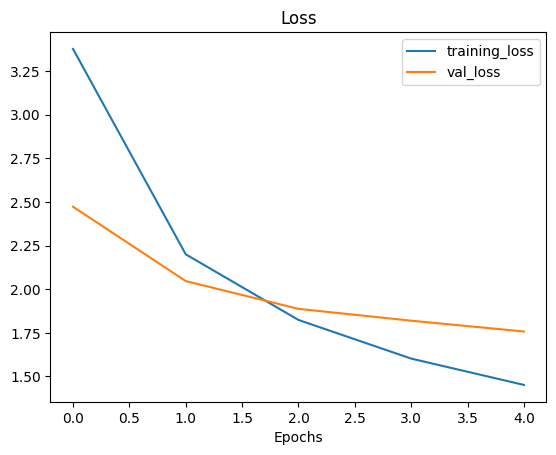

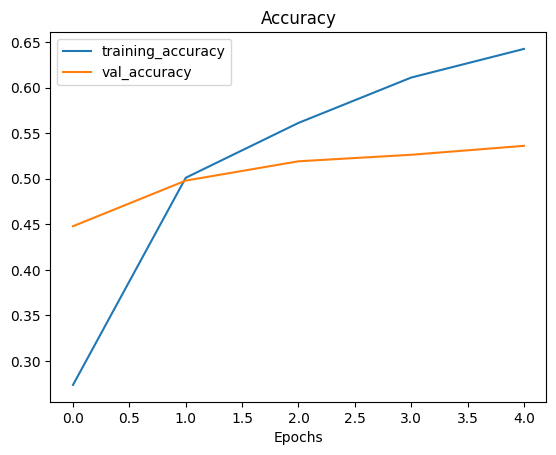

In [57]:
plot_loss_curves(history_all_classes_10_percent
                 )

#Fine Tuning

In [50]:
# Unfreeze edicez ki overfiti kaldıralım yukarıda overfit var çünkü
base_model.trainable=True
# Bütün katmanları refreeze ediyoruz son 5 katman haric

for layer in base_model.layers[:-5]:
  layer.trainable= False

  ## learning rate değerini 10x azaltıyoruz

In [51]:
## Tekrardan compile

model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics =["accuracy"])


In [52]:
## Hangi katmanların eğitilebildiğini ölçümlüyoruz

for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


Dipnot: Global average poolda büyük boyutlu bir tensoru alıp bir özellik vektörüne çevirme işlemi yapılır.

In [53]:
for layer_number, layer in enumerate (model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_14 False
2 normalization_7 False
3 rescaling_15 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

Not: Unfreeze ettikçe learning rate düşürülür

In [54]:
## Fine-tune 5 tane daha fazla epoch için

fine_tune_epochs=10 # model özellik çıkarımı için 5 epochla eğittik, bu toplam epoch sayısıdır, fine-tune için 5,özellik çıkarımı için ise 5
#Fine-tune

history_all_classes_10_percent_fine_tune= model.fit(train_data_all_10_percent, epochs= fine_tune_epochs, validation_data= test_data, validation_steps= int(0.15*len(test_data)), initial_epoch= history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 84s 318ms/step - loss: 1.2001 - accuracy: 0.6892 - val_loss: 1.7209 - val_accuracy: 0.5448
Epoch 6/10
237/237 [==============================] - 66s 275ms/step - loss: 1.0959 - accuracy: 0.7068 - val_loss: 1.7041 - val_accuracy: 0.5490
Epoch 7/10
237/237 [==============================] - 63s 266ms/step - loss: 1.0198 - accuracy: 0.7288 - val_loss: 1.7172 - val_accuracy: 0.5485
Epoch 8/10
237/237 [==============================] - 61s 254ms/step - loss: 0.9310 - accuracy: 0.7489 - val_loss: 1.7447 - val_accuracy: 0.5408
Epoch 9/10
237/237 [==============================] - 60s 253ms/step - loss: 0.8910 - accuracy: 0.7629 - val_loss: 1.7236 - val_accuracy: 0.5421
Epoch 10/10
237/237 [==============================] - 54s 227ms/step - loss: 0.8402 - accuracy: 0.7785 - val_loss: 1.7296 - val_accuracy: 0.5426


In [55]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 57s 72ms/step - loss: 1.5019 - accuracy: 0.6003


[1.5018590688705444, 0.6003168225288391]

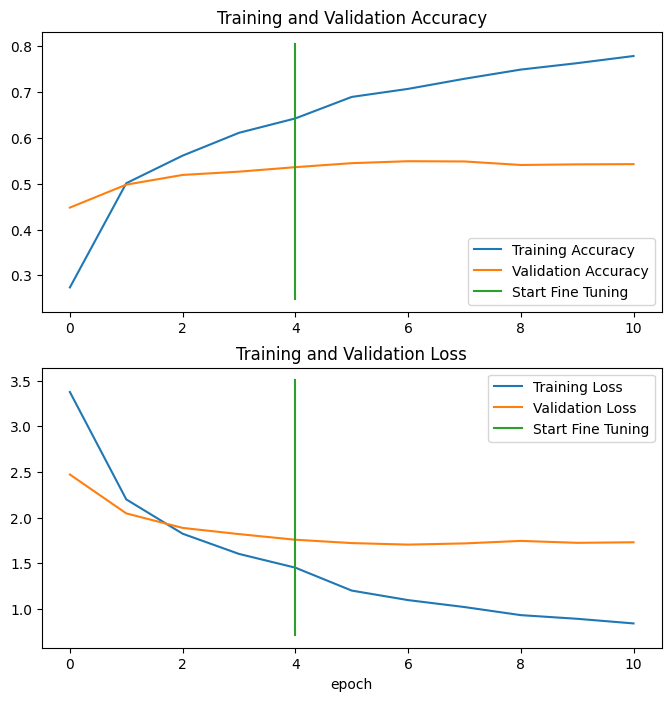

In [59]:
## Özellik çıkarımı modeli ile fine tune olan modelin karşılaştırılması

compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [60]:
## Modelin kaydedilmesi


model.save(" drive/MyDrive/tensorflow,")

In [61]:
#Modelin yüklenmesi

loaded_model = tf.keras.models.load_model(" drive/MyDrive/tensorflow,")

In [ ]:
##